In [463]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.objective_functions import portfolio_variance

os.getcwd()

'/Users/edvardohlstrom/Documents/UCLouvain/Big data in finance'

In [464]:
#global variables

CUMULATIVE = True


# helper functions

def read_clean_data(path):
    df = pd.read_csv(path,low_memory=False)
    df = df.dropna(axis=0) # removes rows with null values
    if "Daily" in path: 
        df ['Date'] = pd.to_datetime(df ['Date'],format="%Y%m%d")
        df  = df [(df ['Date'] >= "1970-01-01") & (df ['Date'] <= "2022-12-31" )]
        df ['Date'] = df ['Date'].dt.strftime('%Y-%m-%d')
    else:
        df['Date'] = pd.to_datetime(df['Date'],format="%Y%m")
        df = df[(df['Date'] >= "1970-01") & (df['Date'] <= "2022-12" )]

    if df['Date'].duplicated().any() :
        print("Contain dublicate dates")

    df  = df.drop(df.columns[0], axis=1) # remove date column
    df = df.astype(float)

    # remove all coulumns with -99.99
    shape = int(df.shape[1])
    columns = list(df.columns)
    specific_value = -99.99
    df = df.loc[:, ~df.isin([specific_value]).any()] 
    if shape != df.shape[1]:
        print(shape-df.shape[1], " number of column droped. The droped columns: ", [x for x in columns if x not in df.columns] )
    
    df  = df*(0.01) #scale to decimals from percentages

    if df.isnull().values.any():
        print("DataFrame contains null values")
    
    non_numeric_df = df.select_dtypes(exclude=['number'])
    non_numeric_values = [val for val in non_numeric_df.stack().tolist()]
    if non_numeric_values == 0:
        print("DataFrame contain non decimal values")

    print( "DONE: Read and cleaned data from path: ", path)
    return df


def get_performance(data, weigth, days_held):
    ret = annulized_return(np.sum((data*weigth).to_numpy()), days_held=days_held)
    var = portfolio_variance(weigth, risk_models.sample_cov(data,returns_data=True))
    sharp = ret/var
    return ret, var, sharp


def annulized_return(cummulative_return, days_held):
    return (1+cummulative_return*0.01)**(365/days_held)-1



def plot_perforamce(data_test, data_val, title=""):
    plt.figure()
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    axs[0].plot(np.array(data_test)[:,0])
    axs[0].plot(np.array(data_val)[:,0])
    axs[0].legend(["Test","Val"])
    axs[0].set_xlabel("Window")
    axs[0].set_ylabel("Annual return")

    axs[1].plot(np.array(data_test)[:,1])
    axs[1].plot(np.array(data_val)[:,1])
    axs[1].legend(["Test","Val"])
    axs[1].set_xlabel("Window")
    axs[1].set_ylabel("Volatility")

    axs[2].plot(np.array(data_test)[:,2])
    axs[2].plot(np.array(data_val)[:,2])
    axs[2].legend(["Test","Val"])
    axs[2].set_xlabel("Window")
    axs[2].set_ylabel("Sharp")

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.savefig("Pictures/" + title)
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    

In [355]:
## tests

# Should be same shape part 1
df_1 = read_clean_data("Data/10_Industry_Portfolios.csv")
df_2 = read_clean_data("Data/25_Portfolios_5x5.CSV")
df_3 = read_clean_data("Data/100_Portfolios_10x10.CSV")
df_4 = read_clean_data("Data/48_Industry_Portfolios.CSV")

if not (len(df_3) == len(df_2) == len(df_3) == len(df_4) ):
    print("Datasets are different length")

# Should be same shape part 2
df = read_clean_data("Data/25_Portfolios_5x5_Daily.csv")
df = read_clean_data("Data/10_Industry_Portfolios_Daily.csv")
df = read_clean_data("Data/100_Portfolios_10x10_Daily.csv")
df = read_clean_data("Data/48_Industry_Portfolios_Daily.csv")

if not (len(df_3) == len(df_2) == len(df_3) == len(df_4) ):
    print("Datasets are different length")

del df_1, df_2, df_3, df_4

Read and cleaned data from path:  Data/10_Industry_Portfolios.csv
Read and cleaned data from path:  Data/25_Portfolios_5x5.CSV
4  number of column droped. The droped columns:  ['ME7 BM10', 'ME10 BM8', 'ME10 BM9', 'BIG HiBM']
Read and cleaned data from path:  Data/100_Portfolios_10x10.CSV
Read and cleaned data from path:  Data/48_Industry_Portfolios.CSV
Read and cleaned data from path:  Data/25_Portfolios_5x5_Daily.csv
Read and cleaned data from path:  Data/10_Industry_Portfolios_Daily.csv
4  number of column droped. The droped columns:  ['ME7 BM10', 'ME10 BM8', 'ME10 BM9', 'BIG HiBM']
Read and cleaned data from path:  Data/100_Portfolios_10x10_Daily.csv
Read and cleaned data from path:  Data/48_Industry_Portfolios_Daily.csv


DONE: Read and cleaned data from path:  Data/10_Industry_Portfolios_Daily.csv


<Figure size 640x480 with 0 Axes>

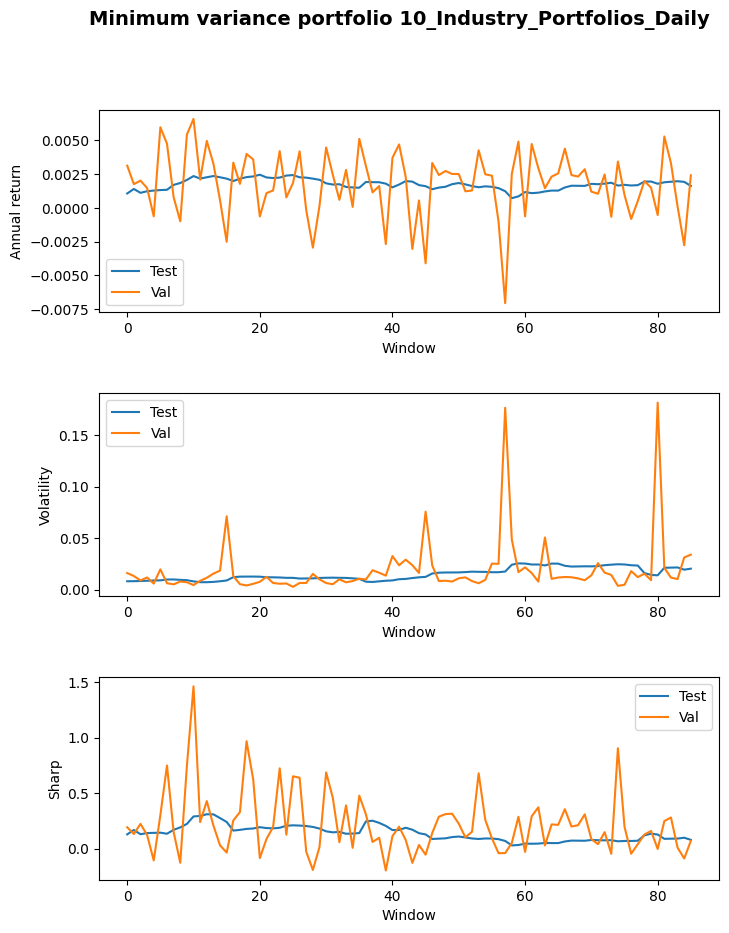

<Figure size 640x480 with 0 Axes>

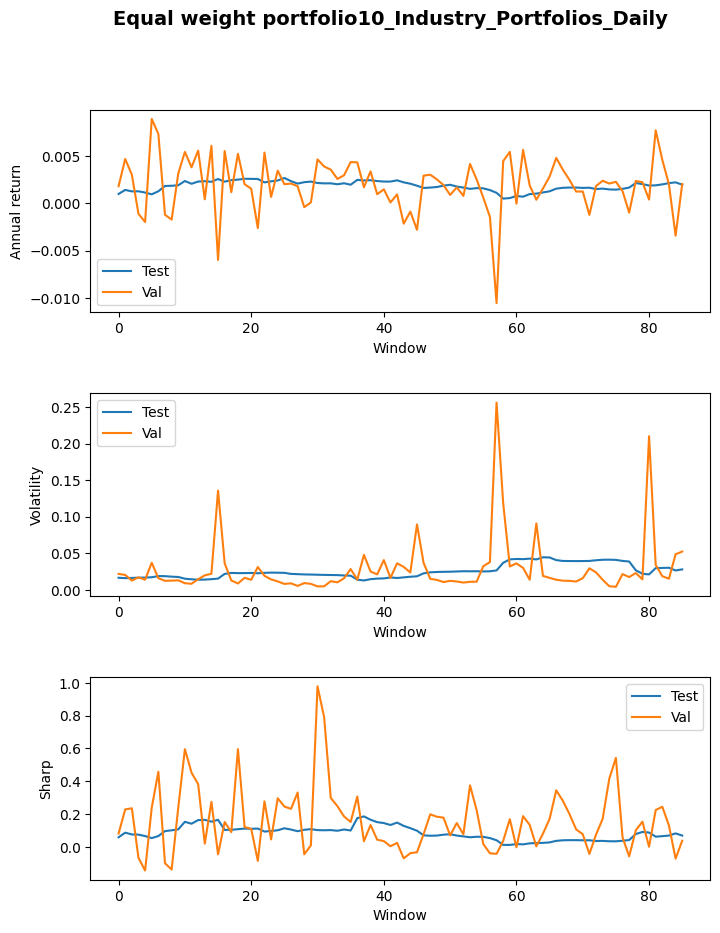

<Figure size 640x480 with 0 Axes>

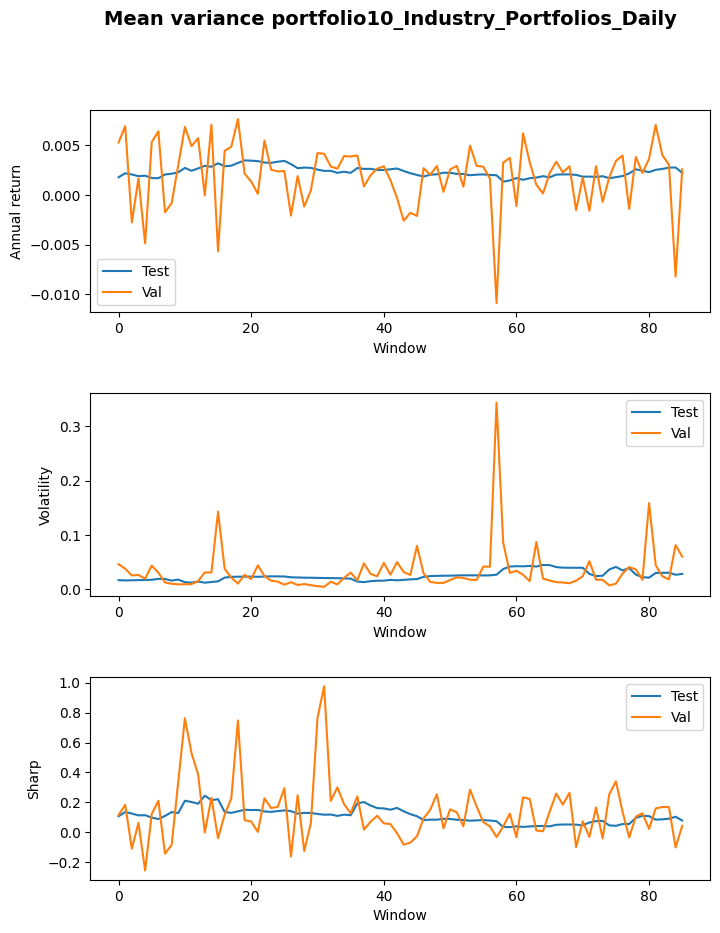

In [466]:

def run_analysis(path):
    df = read_clean_data(path)
    n = len(df)
    year_idx = n//(2023-1970)
    window_size = year_idx*10
    index_increase = window_size//20
    num_of_windows = 86 # (53 years - 10 years ) * 2  

    min_var_test = []
    min_var_val = []

    equal_weigth_test = []
    equal_weigth_val = []

    my_list = df.columns.to_list()
    equal_weights = {k: 1/len(my_list) for k in my_list}

    mean_var_test = []
    mean_var_val = []



    for i in range(num_of_windows):
        temp = df.iloc[(i*index_increase):(window_size+i*index_increase)]

        mu = mean_historical_return(temp, returns_data=True, compounding=False)
        S = risk_models.sample_cov(temp, returns_data=True)

        ef_min = EfficientFrontier(mu, S)
        ef_min.min_volatility()

        ef_equal = EfficientFrontier(mu, S)
        ef_equal.set_weights(equal_weights)

        ef_mean = EfficientFrontier(mu, S)
        mean_var = np.sqrt(np.mean(S.values))
        ef_mean.efficient_risk(mean_var)

        #TEST
        

        equal_weigth_ret_test, equal_weigth_var_test, equal_weigth_sharp_test = get_performance(temp, ef_equal.weights,days_held=window_size)
        equal_weigth_test.append([equal_weigth_ret_test, equal_weigth_var_test, equal_weigth_sharp_test])

        min_var_ret_test, min_var_var_test, min_var_sharp_test = get_performance(temp, ef_min.weights, days_held=window_size)
        min_var_test.append([min_var_ret_test, min_var_var_test, min_var_sharp_test])

        mean_var_ret_test, mean_var_var_test, mean_var_sharp_test = get_performance(temp, ef_mean.weights, days_held=window_size)
        mean_var_test.append([mean_var_ret_test, mean_var_var_test, mean_var_sharp_test])
        #VAL

        temp2 = df.iloc[(window_size+(i)*index_increase):(window_size+(i+1)*index_increase)]
        
        equal_weigth_ret_val, equal_weigth_var_val, equal_weigth_sharp_val = get_performance(temp2, ef_equal.weights, days_held=index_increase)
        equal_weigth_val.append([equal_weigth_ret_val, equal_weigth_var_val, equal_weigth_sharp_val])

        min_var_ret_val, min_var_var_val, min_var_sharp_val = get_performance(temp2, ef_min.weights,  days_held=index_increase)
        min_var_val.append([min_var_ret_val, min_var_var_val, min_var_sharp_val])

        mean_var_ret_val, mean_var_var_val, mean_var_sharp_val = get_performance(temp2, ef_mean.weights,  days_held=index_increase)
        mean_var_val.append([mean_var_ret_val, mean_var_var_val, mean_var_sharp_val])



    plot_perforamce(np.array(min_var_test),np.array(min_var_val), "Minimum variance portfolio " + path[5:-4])
    plot_perforamce(np.array(equal_weigth_test) ,np.array(equal_weigth_val), "Equal weight portfolio"  + path[5:-4])
    plot_perforamce(np.array(mean_var_test), np.array(mean_var_val), "Mean variance portfolio" + path[5:-4])


    # return [get_compareable_performance(min_var_test), get_compareable_performance(min_var_val),\
    #     get_compareable_performance(equal_weigth_test), get_compareable_performance(equal_weigth_val),\
    #     get_compareable_performance(mean_var_ret_test), get_compareable_performance(mean_var_ret_val)]
    




idea data representation


datasets         -  10_Industry_Portfolios.csv - Data/25_Portfolios_5x5.CSV - 100_Portfolios_10x10.CSV
Portfolios

mean_variance_test       mean, variance            mean, variance                mean, variance
mean_variance_val        mean, variance            mean, variance                mean, variance

min_variance_test        mean, variance            mean, variance                mean, variance
min_variance_val         mean, variance            mean, variance                mean, variance

equal_variance_test      mean, variance            mean, variance                mean, variance
equal_variance_val       mean, variance            mean, variance                mean, variance


In [ ]:
path_list = [("Data/10_Industry_Portfolios.csv"), ("Data/25_Portfolios_5x5.CSV"),\
             ("Data/100_Portfolios_10x10.CSV"),("Data/48_Industry_Portfolios.CSV"), \
             ("Data/25_Portfolios_5x5_Daily.csv"),("Data/10_Industry_Portfolios_Daily.csv"), \
             ("Data/100_Portfolios_10x10_Daily.csv"),("Data/48_Industry_Portfolios_Daily.csv")]

variable = []

for path in path_list:
    variable.append(run_analysis(path))

variable

# run_analysis("Data/10_Industry_Portfolios.csv")
# run_analysis("Data/25_Portfolios_5x5.CSV")
# run_analysis("Data/100_Portfolios_10x10.CSV")
# run_analysis("Data/48_Industry_Portfolios.CSV")
# run_analysis("Data/25_Portfolios_5x5_Daily.csv")
# run_analysis("Data/10_Industry_Portfolios_Daily.csv")
# run_analysis("Data/100_Portfolios_10x10_Daily.csv")
# run_analysis("Data/48_Industry_Portfolios_Daily.csv")

Compare the in-sample and out-of-sample performance of three portfolio strategies: sample mean-variance portfolio, sample minimum-variance portfolio and equally weighted portfolio. For the in-sample performance, compute the three portfolios on all returns directly. For the out-of-sample performance, implement a rolling-window approach: use an estimation window of 10 years, compute the out-of-sample performance on the next six months, and then roll over the windows by six months until the end of the sample is achieved. Report the performance in terms of annualized mean, volatility and Sharpe ratio.

Discuss your results and explain why you obtain such results. What is the impact of the return frequency (daily or monthly)? How stable are the portfolio weigths over time (e.g. by computing the turnover or plotting boxplots)?

Sketches

In [454]:
df = read_clean_data("Data/10_Industry_Portfolios_Daily.csv")
mu = mean_historical_return(df, returns_data=True, compounding=False, frequency=252)
S = risk_models.sample_cov(df, returns_data=True, frequency=252)


DONE: Read and cleaned data from path:  Data/10_Industry_Portfolios_Daily.csv


In [449]:
# Max sharpe portofolio
ef = EfficientFrontier(mu, S)

ef.max_sharpe()
ef.portfolio_performance(verbose=True)
df = temp = df.iloc[(0):(126)]

ValueError: at least one of the assets must have an expected return exceeding the risk-free rate

In [451]:
ef = EfficientFrontier(mu, S)
mean_var = np.sqrt(np.mean(S.values))
ef.efficient_risk(mean_var)
ef.portfolio_performance(verbose=True)


Expected annual return: -23.5%
Annual volatility: 11.8%
Sharpe Ratio: -2.16


(-0.23520000018396028, 0.11810616786136385, -2.160767763488193)

In [452]:
#sample minimum-variance portfolio
ef = EfficientFrontier(mu, S)
ef.min_volatility() 
ef.portfolio_performance(verbose=True)


Expected annual return: -23.9%
Annual volatility: 11.8%
Sharpe Ratio: -2.20


(-0.23868899030452956, 0.11768900289594655, -2.1980727505461712)

In [453]:
# equally weighted portfolio
ef = EfficientFrontier(mu, S)


my_list = df.columns.to_list()
my_dict = {k: 0.1 for k in my_list}

ef.set_weights(my_dict)
ef.portfolio_performance(verbose=True)



Expected annual return: -46.5%
Annual volatility: 17.6%
Sharpe Ratio: -2.76


(-0.46470000000000006, 0.1758231094572042, -2.7567479695720962)